#Visualizing the model  
This notebook is meant as an example for how to create visualizations
like the ones provided in the appendix.

It is expected that this might need some slight modification depending on the user's 
setup. 

In [23]:
import theano
from theano import tensor
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

In [24]:
import cPickle as pkl
import numpy

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import skimage
import skimage.transform
import skimage.io

from PIL import Image

In [25]:
import capgen
import generate_caps as gencaps
import flickr8k
import flickr30k
import coco

## Loading the model and dataset  

In [26]:
datasets = {'flickr8k': (flickr8k.load_data, flickr8k.prepare_data),
             'flickr30k': (flickr30k.load_data, flickr30k.prepare_data),
             'coco': (coco.load_data, coco.prepare_data)}

# location of the model file, the pkl file should be named "model_name.npz.pkl"
model= './checkpoints/model2.npz'
# location of the devset split file like the ones in /splits
test_list = './Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt' 
image_path = './Flickr8k/test/'


# load model model_options
with open('%s.pkl'%model, 'rb') as f:
    options = pkl.load(f)

print 'Loading: ' + options['dataset']

flist = []
with open(test_list, 'r') as f:
    for l in f:
        flist.append(l.strip())


Loading: flickr8k


## Visualize input

In [27]:
# keep aspect ratio, and center crop
def LoadImage(file_name, resize=256, crop=224):
    image = Image.open(file_name)
    width, height = image.size

    if width > height:
        width = (width * resize) / height
        height = resize
    else:
        height = (height * resize) / width
        width = resize
    left = (width  - crop) / 2
    top  = (height - crop) / 2
    image_resized = image.resize((width, height), Image.BICUBIC).crop((left, top, left + crop, top + crop))
    data = numpy.array(image_resized.convert('RGB').getdata()).reshape(crop, crop, 3)
    data = data.astype('float32') / 255
    return data

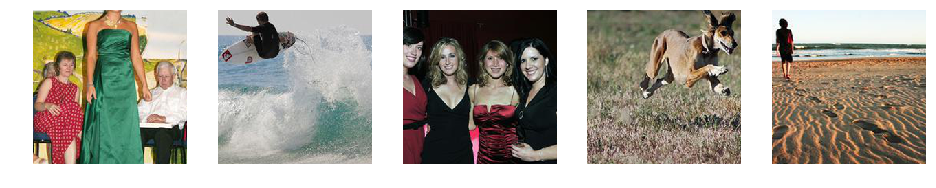

In [28]:
import os
imgs = os.listdir('./Flickr8k/test/')
input_path = imgs

fig1 = plt.figure(figsize=(16,8))
for i in list(range(5)):
    plt.subplot(1,5,i+1)
    img = LoadImage(image_path+input_path[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [29]:
    load_data, prepare_data = datasets[options['dataset']]

    train, valid, test, worddict = load_data(False, False, True)
    print 'Data loaded'

    word_idict = dict()
    for kk, vv in worddict.iteritems():
        word_idict[vv] = kk
    word_idict[0] = '<eos>'
    word_idict[1] = 'UNK'

... loading data
Data loaded


## Creating the Theano Graph  

In [30]:
    # build the sampling functions and model
    trng = RandomStreams(1234)
    use_noise = theano.shared(numpy.float32(0.), name='use_noise')

    params = capgen.init_params(options)
    params = capgen.load_params(model, params)
    tparams = capgen.init_tparams(params)

    # word index
    f_init, f_next = capgen.build_sampler(tparams, options, use_noise, trng)

Building f_init... Done


In [31]:
    trng, use_noise, \
          inps, alphas, alphas_samples, \
          cost, opt_outs = \
          capgen.build_model(tparams, options)

In [32]:
# get the alphas and selector value [called \beta in the paper]

# create update rules for the stochastic attention
hard_attn_updates = []
if options['attn_type'] == 'stochastic':
    baseline_time = theano.shared(numpy.float32(0.), name='baseline_time')
    hard_attn_updates += [(baseline_time, baseline_time * 0.9 + 0.1 * opt_outs['masked_cost'].mean())]
    hard_attn_updates += opt_outs['attn_updates']
    
f_alpha = theano.function(inps, alphas, name='f_alpha', updates=hard_attn_updates)
if options['selector']:
    f_sels = theano.function(inps, opt_outs['selector'], name='f_sels', updates=hard_attn_updates)

/home/alvinai9603/anaconda3/envs/theano_gpu_py2/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
/home/alvinai9603/anaconda3/envs/theano_gpu_py2/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


## Generating the Caption and Attention Visualization

(The next five cells can be run over and over to visualize a random image)

In [33]:
# n*5 only show n imgs' ground-truth captions
n=24
#test[0][0:n*5]
k = 15 # beam width
contexts = [numpy.array(test[1][i]).reshape([14*14, 512]) for i in range(n)]
imgs_array_list = [LoadImage(image_path+imgs[i]) for i in list(range(n))]

sample 0: a blond girl in a green dress and elaborate gold necklace stands in front of a few women and a man
sample 1: a lone surfboarder on a white surfboard flying through the air over a wave
sample 2: four girls in evening attire pose for a picture
sample 3: a tan dog and a cream colored dog run through grasslands
sample 4: a lone person walking in the distance on a long beach
sample 5: a boy soccer player running down the field
sample 6: a family picture
sample 7: a blonde boy stands among people in a shady setting with a large snake wrapped around his chest
sample 8: a girl dressed in a red dress and another girl dressed as a pirate are playing around
sample 9: a break dancer spins on his head outside as onlookers watch the performance
sample 10: a black dog is slowly crossing a fallen log that is outstretched over a stream of water
sample 11: one girl is wearing a white tshirt with red sleeves  the other has words on hers
sample 12: a dog jumps up towards a woman in a car  while 

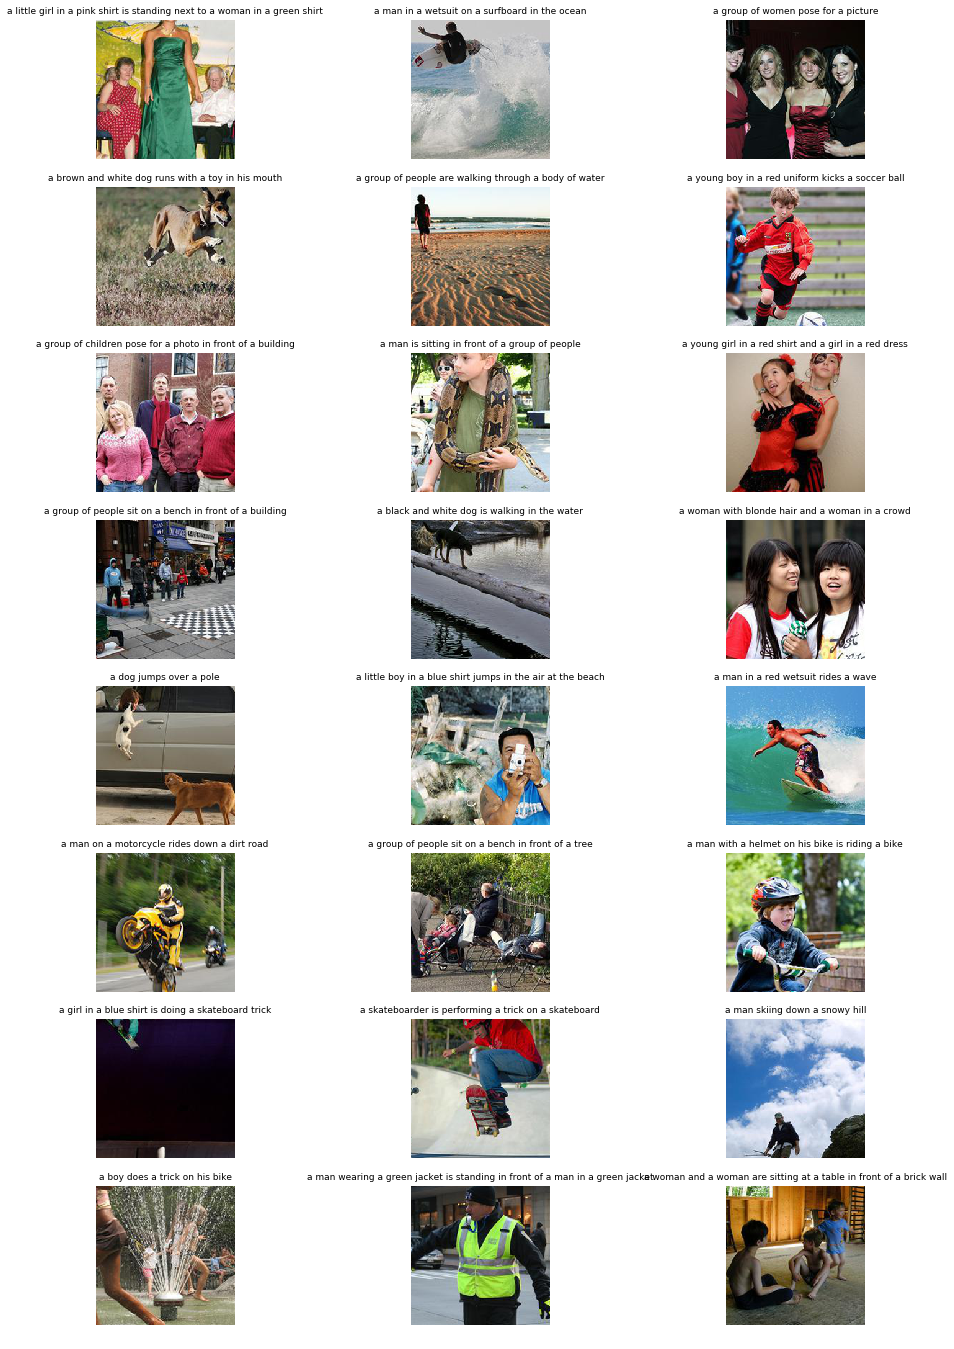

In [16]:
fig = plt.figure(figsize=(16,n))

for i in range(n):
    plt.subplot(n/3,3,i+1)
    img = LoadImage(image_path+input_path[i])
    plt.imshow(img)
    plt.axis('off')
    
    sample, score = capgen.gen_sample(tparams, f_init, f_next, contexts[i], 
                                      options, trng=trng, k=k, maxlen=100, stochastic=False)
    # adjust for length bias
    lengths = numpy.array([len(s) for s in sample])
    score = score / lengths
    sidx = numpy.argmin(score)    
    caption = sample[sidx][:-1]    
    words = map(lambda w: word_idict[w] if w in word_idict else '<UNK>', caption)
    
    plt.title(' '.join(words), fontsize=9)
    print 'sample %d:'%i, test[0][5*i][0]
plt.show()

In [34]:
captions = []
words_list = []
for i in range(n):
    sample, score = capgen.gen_sample(tparams, f_init, f_next, contexts[i], 
                                      options, trng=trng, k=k, maxlen=100, stochastic=False)
    # adjust for length bias
    lengths = numpy.array([len(s) for s in sample])
    score = score / lengths
    sidx = numpy.argmin(score)
    
    caption = sample[sidx][:-1]
    captions.append(caption)
    words = map(lambda w: word_idict[w] if w in word_idict else '<UNK>', caption)
    words_list.append(words)
    print 'Sample %d:' % int(i+1) , ' '.join(words)
    #print 'GT:'
    #for c in test[0][5*i:(5*i)+5]:
        #rint c[0]
    #print 

Sample 1: a little girl in a pink shirt is standing next to a woman in a green shirt
Sample 2: a man in a wetsuit on a surfboard in the ocean
Sample 3: a group of women pose for a picture
Sample 4: a brown and white dog runs with a toy in his mouth
Sample 5: a group of people are walking through a body of water
Sample 6: a young boy in a red uniform kicks a soccer ball
Sample 7: a group of children pose for a photo in front of a building
Sample 8: a man is sitting in front of a group of people
Sample 9: a young girl in a red shirt and a girl in a red dress
Sample 10: a group of people sit on a bench in front of a building
Sample 11: a black and white dog is walking in the water
Sample 12: a woman with blonde hair and a woman in a crowd
Sample 13: a dog jumps over a pole
Sample 14: a little boy in a blue shirt jumps in the air at the beach
Sample 15: a man in a red wetsuit rides a wave
Sample 16: a man on a motorcycle rides down a dirt road
Sample 17: a group of people sit on a bench in

In [35]:
# only focus on the sample_no image
sample_no = 2

In [36]:
# only focus on the second image - 'a surfer jumps a wave'
alpha = f_alpha(numpy.array(captions[sample_no]).reshape(len(captions[sample_no]),1), 
                numpy.ones((len(captions[sample_no]),1), dtype='float32'), 
                contexts[sample_no].reshape(1,contexts[sample_no].shape[0],contexts[sample_no].shape[1]))
if options['selector']:
    sels = f_sels(numpy.array(captions[sample_no]).reshape(len(captions[sample_no]),1), 
                   numpy.ones((len(captions[sample_no]),1), dtype='float32'), 
                   contexts[sample_no].reshape(1,contexts[sample_no].shape[0],contexts[sample_no].shape[1]))

## Displaying the Visualization   

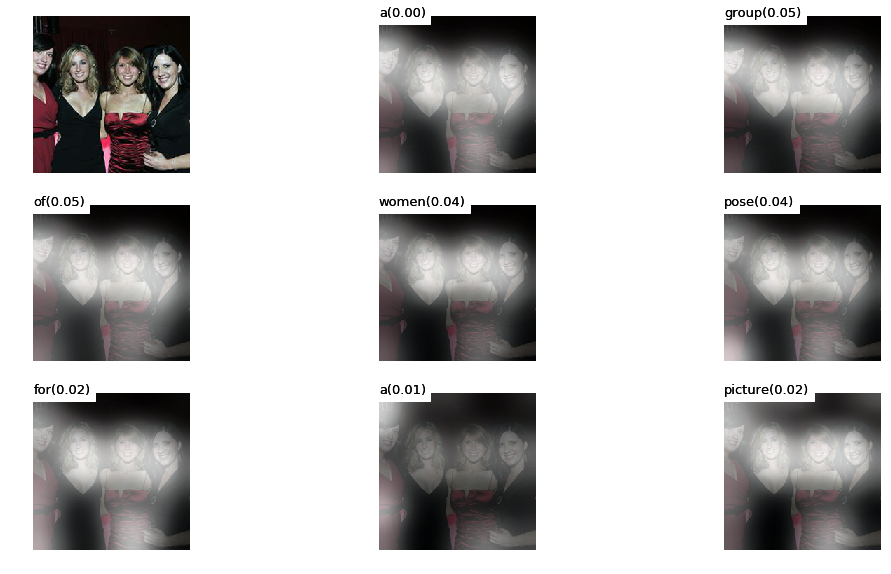

In [37]:
# display the visualization
n_words = alpha.shape[0] + 1
w = numpy.round(numpy.sqrt(n_words))
h = numpy.ceil(numpy.float32(n_words) / w)


fig = plt.figure(figsize=(16,8))
plt.subplot(w,h,1)
#plt.subplot(1, n_words, 1)
img = LoadImage(image_path+input_path[sample_no])
plt.imshow(img)
plt.axis('off')

smooth = True

for ii in xrange(alpha.shape[0]):
    plt.subplot(w, h, ii+2)
    lab = words_list[sample_no][ii]
    if options['selector']:
        lab += '(%0.2f)'%sels[ii]
    plt.text(0, 1, lab, backgroundcolor='white', fontsize=13)
    plt.text(0, 1, lab, color='black', fontsize=13)
    plt.imshow(img)
    if smooth:
        alpha_img = skimage.transform.pyramid_expand(alpha[ii,0,:].reshape(14,14), upscale=16, sigma=20)
    else:
        alpha_img = skimage.transform.resize(alpha[ii,0,:].reshape(14,14), [img.shape[0], img.shape[1]])
    plt.imshow(alpha_img, alpha=0.8)
    plt.set_cmap(cm.Greys_r)
    plt.axis('off')
plt.tight_layout()
plt.show()